<img src="resources/titanic_sinking.gif" alt="Titanic sinking gif" style="margin: 10px auto 20px;" width="100%"/>

<a id="project-overview"></a>
_**Potonuće Titanika** jedno je od najozloglašenijih brodoloma u istoriji._

_15. aprila 1912. godine, tokom njegovog prvog putovanja, široko smatrani „nepotopivi“ RMS Titanic potonuo je nakon sudara sa santom leda u severnom Atlantskom okeanu. Nažalost, nije bilo dovoljno čamaca za spasavanje za sve na brodu, što je rezultovalo smrću 1502 od 2224 putnika i posade._

_Iako je u preživljavanju učestvovao neki element sreće, čini se da su neke grupe ljudi imale veću verovatnoću preživljavanja u odnosu na druge._

Ovaj projekat predstavlja prediktivni model koji odgovara na pitanje: _„za koje vrste ljudi je veća verovatnoća da će preživeti?“_ korišćenjem dostupnih podataka o putnicima (tj. ime, starost, pol, socijalno-ekonomska klasa, itd.).

<hr>

<a id="table-of-contents"></a>
### Pregled sadržaja:
* [Pregled projekta](#project-overview)
* [Učitavanje i obrada skupa podataka](#loading-datasets)
* [Prikaz test podataka u vidu histograma](#hist-display)

<hr>

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

### Učitavanje i obrada skupa podataka <a id="loading-datasets"></a>
<a href="#table-of-contents"> Povratak na pregled sadržaja </a>

<div style="display: inline-block;">

| Variable | Definition                               | Key                                            |
|----------|------------------------------------------|------------------------------------------------|
| Survived | Yes or No                                | 1 or 0                                         |
| Pclass   | A proxy of socio-economic status (SES)   | 1 = Upper,  2 = Middle, 3 = Lower              |
| Name     | Passenger name                           | e.g. Allen, Mr. William Henry                  |
| Sex      | Passenger sex                            | male or female                                 |
| Age      | Passenger age                            | integer                                        |
| SibSp    | # of siblings/spouses aboard the Titanic | integer                                        |
| Parch    | # of parents/children aboard the Titanic | integer                                        |
| Ticket   | Ticket number                            | e.g. A/5 21171                                 |
| Fare     | Passenger fare                           | float                                          |
| Cabin    | Cabin number (str)                       | e.g. B42                                       |
| Embarked | Port of Embarkation                      | C = Cherbourg, Q = Queenstown, S = Southampton |
    
    
</div>

In [124]:
# ucitavanje u uklanjanje redova koji imaju prazne celije ili celije sa vrednoscu NaN
train_df = pd.read_csv("datasets/train.csv", index_col="PassengerId").dropna()
test_df = pd.read_csv("datasets/test.csv", index_col="PassengerId").dropna()
gender_submission_df = pd.read_csv("datasets/gender_submission.csv").dropna()

# kodiranje kategorickih podataka u numericke
label_encoder = LabelEncoder()
train_sex = label_encoder.fit_transform(train_df["Sex"])
test_sex = label_encoder.fit_transform(test_df["Sex"])

train_embarked = label_encoder.fit_transform(train_df["Embarked"])
test_embarked = label_encoder.fit_transform(test_df["Embarked"])

# podela na trening i test
train_x = np.column_stack([train_df["Pclass"], train_sex, train_df["SibSp"], train_df["Fare"], train_embarked])
train_y = train_df["Survived"]
test_x =  np.column_stack([test_df["Pclass"], test_sex, test_df["SibSp"], test_df["Fare"], test_embarked])

### Prikaz test podataka u vidu histograma <a id="hist-display"></a>
<a href="#table-of-contents"> Povratak na pregled sadržaja </a>

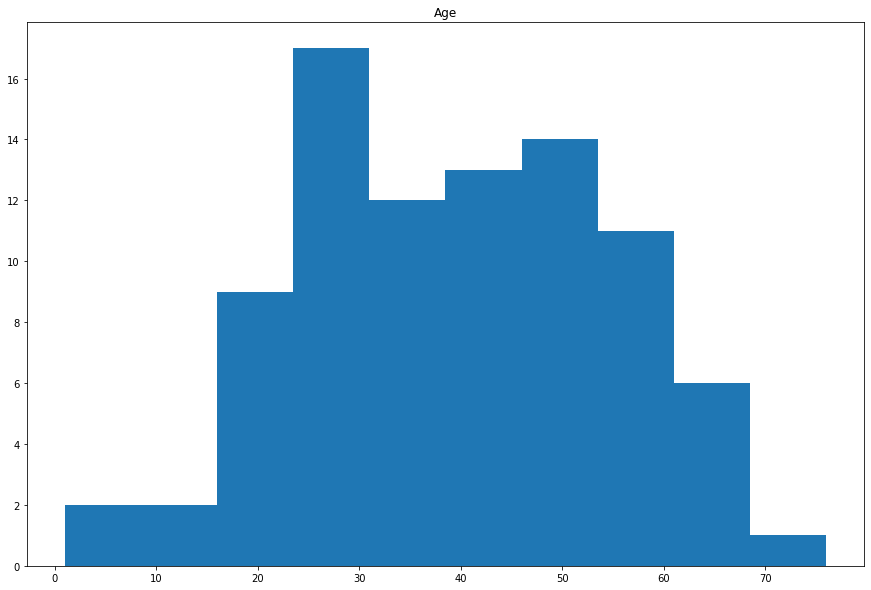

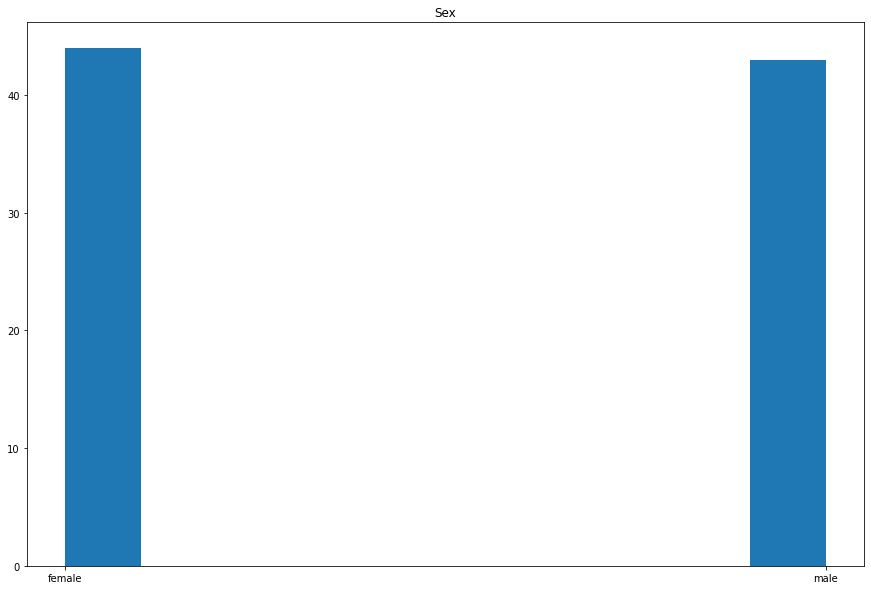

In [139]:
for category in ["Age", "Sex"]:
    plt.figure(figsize=(15, 10))
    plt.hist(test_df[category])
    plt.title(category)
    plt.show()